# <div align=center> Project Text Mining </div>

In [221]:
import nltk
import pandas as pd
from nltk.corpus import brown #we kunnen hier ook een andere gebruiken ipv brown
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
import time
import gensim
from sklearn.model_selection import train_test_split
from PIL import Image
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import gensim
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from langdetect import detect
import collections as c
import matplotlib.pyplot as plt
from gensim.models import LdaModel
import random

In [2]:
#nltk.download() 

In [3]:
nlp = spacy.load('en_core_web_sm') # en_core_web_sm

In [211]:
english_stopwords = stopwords.words('english')
set_english_stopwords = set(english_stopwords)
useful_pos = ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS']
punctuation_table = {ord(char): '' for char in string.punctuation}
porter = PorterStemmer()
vader_model = SentimentIntensityAnalyzer()
nonsense_artists = ['dicaiaaoi-aeaenaiad', 'adaaeaaineay-iaidiia', 'butterfly-temple', 'eica-thdee',
                    'eaoei-iaaae', 'eidieu-e-ooo', 'aoeouii', 'eaniiiaae', 'active-member', 'aa',
                    'denyo', 'aeaadeoi', 'aao', 'ciiiade', 'aeneioaea-aaadey', 'aeena', 'dd-ddeg-dnddeg',
                    'galena', 'caioeda', 'eaeeiia-iino', 'eeii', 'aaid-eaoia', 'edaiaoidee', 'daciia',
                    'civil', 'eyien-odoaaoeie', 'diiainu', 'caoee-io', 'the-early-bird-specials', 'ethay',
                    'adey', 'eaai-eoiaea']

**Function for preprocessing the lyrics**

In [246]:
def preprocessing(lyrics):
    #Lower case and tokenize the words in the lyrics
    tokenized = nltk.word_tokenize(lyrics.lower())
    
    #POS tag the tokens
    tagged = nltk.pos_tag(tokenized)
    
    #Get all verbs, nouns and adjectives
    #Remove stopwords and punctuation, and stem the tokens
    #Remove empty strings and short (len < 2) tokens

    preprocessed_lyrics = []
    for token in tagged:
        if token[1] in useful_pos and token[0] not in set_english_stopwords:
            token_clean = porter.stem(token[0].translate(punctuation_table)) #also remove punctuation
            if len(token_clean) > 2:
                preprocessed_lyrics.append(token_clean)
            else:
                continue

    return preprocessed_lyrics

**Function for changing the vader sentiment output to a label**

In [210]:
def vader_output_to_label(vader_output):
    """
    map vader output e.g.,
    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}
    to one of the following values:
    a) positive float -> 'positive'
    b) 0.0 -> 'neutral'
    c) negative float -> 'negative'
    
    :param dict vader_output: output dict from vader
    
    :rtype: str
    :return: 'negative' | 'neutral' | 'positive'
    """
    compound = vader_output['compound']
    
    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    elif compound > 0.0:
        return 'positive'
    
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0}) == 'neutral'
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.01}) == 'positive'
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': -0.01}) == 'negative'

**Read the dataset**

In [247]:
#Data van deze kaggle: https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics/kernels
#380,000+ lyrics from MetroLyrics
#Lyrics, Artist , Genre, Year
data = pd.read_csv('lyrics.csv', usecols=['song', 'year', 'artist', 'genre', 'lyrics'], error_bad_lines=False)

In [248]:
#preprocessing(data['lyrics'].iloc[25])

In [249]:
# Strange lyric from nonsense artist list
data['lyrics'].iloc[101685]

', ,\n,\n, ,\n.\n,\n.\n.\n, , : " !"\n, .\n, , .\n, , !\n.\n:\n, .\n, - , ,\n.\n.\n-, , .\n, !...\n, , !\n!\n-, , .\n, , !\n... !'

In [250]:
# Show first 5 rows
data.head()

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


**Remove unusable lyrics**  
Some lyrics are empty or extremely short/long and some lyrics have a genre 'Not Available' or 'other'.
These are removed from the dataset.

In [251]:
#Genres before removing 'Not Available' and 'Other', and the unusable lyrics
genres = []
for genre in data['genre']:
    if genre not in genres:
        genres.append(genre)

print(genres)

['Pop', 'Hip-Hop', 'Not Available', 'Other', 'Rock', 'Metal', 'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie']


In [252]:
to_remove_ids = []
for i in range(0, data.shape[0]):

    artist = data['artist'].iloc[i]
    lyric = data['lyrics'].iloc[i]
    genre = data['genre'].iloc[i]

    if artist in nonsense_artists:
        to_remove_ids.append(i)
        continue
    elif type(lyric) != str:
        to_remove_ids.append(i)
        continue
    elif len(lyric.split()) < 40:
        to_remove_ids.append(i)
        continue
    elif len(lyric.split()) >= 1000:
        to_remove_ids.append(i)
        continue
    elif genre == 'Not Available':
        to_remove_ids.append(i)
    elif genre == 'Other':
        to_remove_ids.append(i)
    elif genre == 'Country':
        to_remove_ids.append(i)
    elif genre == 'Jazz':
        to_remove_ids.append(i)
    elif genre == 'Electronic':
        to_remove_ids.append(i)
    elif genre == 'R&B':
        to_remove_ids.append(i)
    elif genre == 'Indie':
        to_remove_ids.append(i)
    elif genre == 'Folk':
        to_remove_ids.append(i)
        continue

    lyrics_language = detect(lyric[:200])
    if lyrics_language != 'en':
        to_remove_ids.append(i)


In [253]:
#Remove the lyrics from the dataframe as determined above
to_remove_ids = list(dict.fromkeys(to_remove_ids))
print(to_remove_ids[:20])
print("number of songs to remove:", len(to_remove_ids))
print(type(to_remove_ids))

data = data.drop(to_remove_ids)
print(data.shape)

[24, 31, 32, 43, 47, 48, 49, 85, 89, 95, 101, 113, 149, 158, 181, 188, 189, 206, 231, 305]
number of songs to remove: 186845
<class 'list'>
(175392, 5)


In [254]:
# Create new csv file with cleaned dataset

data.to_csv('data_schoon_index_false.csv', index = False, header=True)

In [108]:
# Read the new csv file with the cleaned data (only necessary if the code above hasn't been run)

data = pd.read_csv('data_schoon_index_false.csv', usecols=['song', 'year', 'artist', 'genre', 'lyrics'])
data['index'] = data.index

In [109]:
data.head()

,song,year,artist,genre,lyrics,index
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...",0
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...",1
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,2
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...",3
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...",4


In [110]:
data.shape

(175392, 6)

In [111]:
#Genres after filterering to check if all genre are still represented.
genres = []
for genre in data['genre']:
    if genre not in genres:
        genres.append(genre)

print(genres)

['Pop', 'Hip-Hop', 'Rock', 'Metal']


In [112]:
data_original = data
print(data_original.shape)

(175392, 6)


**Take a sample from the dataset**  
The dataset consists of 175425 songs (after removing 'nonsense' data).
The code takes a long time to run for all songs, therefore a sample set is taken to work on the code.
Undersampling is used to get even samples from the four genres.

In [264]:
# Print the amount of songs from each genre
data['genre'].value_counts()

Rock       98782
Pop        34054
Hip-Hop    21966
Metal      20590
Name: genre, dtype: int64

In [265]:
# Undersample the rock genre by taking the same amount of samples from each genre randomly
# The smallest sample set is Metal, so this will be used as the sample size for each genre.
data['grouped genre'] = data['genre']
sample_size = 20590
data_undersampled = data.groupby('grouped genre').apply(lambda x: x.sample(sample_size))
data_undersampled = data_undersampled.drop(columns='grouped genre')
data = data.drop(columns='grouped genre')
data_undersampled.shape

(82360, 6)

In [266]:
data_undersampled.head()

song  year                artist  \
grouped genre                                                                  
Hip-Hop       15161                    this-life  2006  bone-thugs-n-harmony   
              100660  panda-charlie-heat-version  2016             desiigner   
              56781            between-the-lines  2010           chris-brown   
              167707            how-much-we-grew  2006          busta-rhymes   
              58423                     young-og  2013              fabolous   

                        genre  \
grouped genre                   
Hip-Hop       15161   Hip-Hop   
              100660  Hip-Hop   
              56781   Hip-Hop   
              167707  Hip-Hop   
              58423   Hip-Hop   

                                                                 lyrics  \
grouped genre                                                             
Hip-Hop       15161   You don't want to live this life\nNo, this lif...   
              100660  This what they all been waiting for\nI guess s...   
              56781   Was it something I said\nWas it something I di...   
              167707  Yeah this next joint right here\nIs dedicated ...   
              58423   Troubled tears, they'll land you there\nOpen y...   

                       index  
grouped genre                 
Hip-Hop       15161    15161  
              100660  100660  
              56781    56781  
              167707  167707  
              58423    58423

In [267]:
# Print the amount of songs from each genre after sampling
data_undersampled['genre'].value_counts()

Metal      20590
Rock       20590
Hip-Hop    20590
Pop        20590
Name: genre, dtype: int64

**Preprocess the lyrics**    
Preprocess the lyrics using the function 'preprocessing' function from the top of the notebook.

In [268]:
preprocessed_data = data_undersampled['lyrics'].map(preprocessing)

In [234]:
# preprocessed_data['indexmaybe'] = preprocessed_data.index
# preprocessed_data.head()

In [269]:
type(preprocessed_data)

pandas.core.series.Series

In [270]:
preprocessed_data[:10]

grouped genre        
Hip-Hop        15161     [want, live, life, life, nice, want, live, lif...
               100660    [wait, guess, wait, shit, long, time, ima, giv...
               56781     [someth, said, someth, look, answer, caus, kno...
               167707    [yeah, next, joint, right, dedic, nigga, love,...
               58423     [troubl, tear, land, open, eye, disguis, fear,...
               60498     [put, come, jojo, hahaha, yeah, type, shit, th...
               113906    [hot, sun, undon, readi, run, look, barrel, sh...
               59700     [know, wan, ride, tonight, night, shotgun, cou...
               87302     [talib, kweli, place, doom, talib, kweli, born...
               108700    [push, king, new, york, see, gangster, tri, ri...
Name: lyrics, dtype: object

In [271]:
preprocessed_clean_series = preprocessed_data
preprocessed_clean_series.head()

grouped genre        
Hip-Hop        15161     [want, live, life, life, nice, want, live, lif...
               100660    [wait, guess, wait, shit, long, time, ima, giv...
               56781     [someth, said, someth, look, answer, caus, kno...
               167707    [yeah, next, joint, right, dedic, nigga, love,...
               58423     [troubl, tear, land, open, eye, disguis, fear,...
Name: lyrics, dtype: object

In [272]:
data_undersampled['processed lyrics'] = preprocessed_clean_series

In [273]:
data_undersampled.head()

song  year                artist  \
grouped genre                                                                  
Hip-Hop       15161                    this-life  2006  bone-thugs-n-harmony   
              100660  panda-charlie-heat-version  2016             desiigner   
              56781            between-the-lines  2010           chris-brown   
              167707            how-much-we-grew  2006          busta-rhymes   
              58423                     young-og  2013              fabolous   

                        genre  \
grouped genre                   
Hip-Hop       15161   Hip-Hop   
              100660  Hip-Hop   
              56781   Hip-Hop   
              167707  Hip-Hop   
              58423   Hip-Hop   

                                                                 lyrics  \
grouped genre                                                             
Hip-Hop       15161   You don't want to live this life\nNo, this lif...   
              100660  This what they all been waiting for\nI guess s...   
              56781   Was it something I said\nWas it something I di...   
              167707  Yeah this next joint right here\nIs dedicated ...   
              58423   Troubled tears, they'll land you there\nOpen y...   

                       index  \
grouped genre                  
Hip-Hop       15161    15161   
              100660  100660   
              56781    56781   
              167707  167707   
              58423    58423   

                                                       processed lyrics  
grouped genre                                                            
Hip-Hop       15161   [want, live, life, life, nice, want, live, lif...  
              100660  [wait, guess, wait, shit, long, time, ima, giv...  
              56781   [someth, said, someth, look, answer, caus, kno...  
              167707  [yeah, next, joint, right, dedic, nigga, love,...  
              58423   [troubl, tear, land, open, eye, disguis, fear,...

In [274]:
data_undersampled = data_undersampled.drop(columns="lyrics")
data_undersampled = data_undersampled.rename(columns={"processed lyrics": "lyrics"})

In [275]:
data_undersampled.head()

song  year                artist  \
grouped genre                                                                  
Hip-Hop       15161                    this-life  2006  bone-thugs-n-harmony   
              100660  panda-charlie-heat-version  2016             desiigner   
              56781            between-the-lines  2010           chris-brown   
              167707            how-much-we-grew  2006          busta-rhymes   
              58423                     young-og  2013              fabolous   

                        genre   index  \
grouped genre                           
Hip-Hop       15161   Hip-Hop   15161   
              100660  Hip-Hop  100660   
              56781   Hip-Hop   56781   
              167707  Hip-Hop  167707   
              58423   Hip-Hop   58423   

                                                                 lyrics  
grouped genre                                                            
Hip-Hop       15161   [want, live, life, life, nice, want, live, lif...  
              100660  [wait, guess, wait, shit, long, time, ima, giv...  
              56781   [someth, said, someth, look, answer, caus, kno...  
              167707  [yeah, next, joint, right, dedic, nigga, love,...  
              58423   [troubl, tear, land, open, eye, disguis, fear,...

In [278]:
# Create new csv file with cleaned dataset

data_undersampled.to_pickle('data_undersampled_preprocessed_index_false.csv')


In [5]:
# Read the new csv file with the cleaned data (only necessary if the code above hasn't been run)

final_data = pd.read_pickle('data_undersampled_preprocessed_index_false.csv') #, usecols=['genre', 'song', 'year', 'artist', 'genre', 'lyrics'])


In [6]:
final_data.head()

song  year                artist  \
grouped genre                                                                  
Hip-Hop       15161                    this-life  2006  bone-thugs-n-harmony   
              100660  panda-charlie-heat-version  2016             desiigner   
              56781            between-the-lines  2010           chris-brown   
              167707            how-much-we-grew  2006          busta-rhymes   
              58423                     young-og  2013              fabolous   

                        genre   index  \
grouped genre                           
Hip-Hop       15161   Hip-Hop   15161   
              100660  Hip-Hop  100660   
              56781   Hip-Hop   56781   
              167707  Hip-Hop  167707   
              58423   Hip-Hop   58423   

                                                                 lyrics  
grouped genre                                                            
Hip-Hop       15161   [want, live, life, life, nice, want, live, lif...  
              100660  [wait, guess, wait, shit, long, time, ima, giv...  
              56781   [someth, said, someth, look, answer, caus, kno...  
              167707  [yeah, next, joint, right, dedic, nigga, love,...  
              58423   [troubl, tear, land, open, eye, disguis, fear,...

**Train and Test sets**  
The dataset (or sample set) is split into a train and a test set.
80% of the dataset is for training, 20% for testing.

In [7]:
#Split the dataset into a training and a testing set using an 80-20 split
train, test = train_test_split(final_data, test_size=0.2)

In [8]:
#Split the test set into a validation and a testing set using an 80-20 split
validate, test = train_test_split(test, test_size=0.2)

In [9]:
print(type(train))
print(train.shape)
print(type(validate))
print(validate.shape)
print(type(test))
print(test.shape)

<class 'pandas.core.frame.DataFrame'>
(65888, 6)
<class 'pandas.core.frame.DataFrame'>
(13177, 6)
<class 'pandas.core.frame.DataFrame'>
(3295, 6)


In [10]:
print(train['lyrics'][:10])
print(type(train['lyrics']))
#pro_lyrics = train['lyrics']
#print(pro_lyrics[:10])

grouped genre        
Pop            40641     [decid, went, start, gone, think, mean, keep, ...
Hip-Hop        138512    [lil, wayn, bow, wow, angel, straight, heaven,...
Pop            57705     [matter, hard, tri, keep, push, break, talk, s...
Hip-Hop        60494     [shit, tire, gettin, shot, tire, gettin, chase...
Rock           61836     [drop, penni, said, feel, liber, take, love, r...
Pop            128928    [everyon, tell, need, hide, friend, sad, true,...
               6782      [music, key, fall, love, music, answer, world,...
Metal          137209    [want, hear, tri, help, want, see, tri, save, ...
Pop            48047     [gave, heart, ooh, ooh, gave, heart, ooh, ooh,...
               107294    [afraid, say, love, anymor, word, wait, time, ...
Name: lyrics, dtype: object
<class 'pandas.core.series.Series'>


In [11]:
train.head()

,,song,year,artist,genre,index,lyrics
grouped genre,,,,,,,
Pop,40641,believe,2016,cant,Pop,40641,"[decid, went, start, gone, think, mean, keep, ..."
Hip-Hop,138512,can-i-be-your-man,2009,bow-wow,Hip-Hop,138512,"[lil, wayn, bow, wow, angel, straight, heaven,..."
Pop,57705,believe,2012,ella-henderson,Pop,57705,"[matter, hard, tri, keep, push, break, talk, s..."
Hip-Hop,60494,thugz-mansion,2006,2pac,Hip-Hop,60494,"[shit, tire, gettin, shot, tire, gettin, chase..."
Rock,61836,take-my-love-and-run,2014,bad-suns,Rock,61836,"[drop, penni, said, feel, liber, take, love, r..."


In [12]:
validate.head()

song  year                      artist  \
grouped genre                                                             
Rock          175088  naked-in-my-bed  2004                   frickin-a   
              74437            eh-hee  2010  dave-matthews-tim-reynolds   
Hip-Hop       97466       outshine-me  2014                   colt-ford   
Rock          141048    morningleaver  2007             as-friends-rust   
Pop           147766     falling-down  2009               american-idol   

                        genre   index  \
grouped genre                           
Rock          175088     Rock  175088   
              74437      Rock   74437   
Hip-Hop       97466   Hip-Hop   97466   
Rock          141048     Rock  141048   
Pop           147766      Pop  147766   

                                                                 lyrics  
grouped genre                                                            
Rock          175088  [met, pool, yeah, smokin, hot, told, get, ask,...  
              74437   [chant, prais, god, mani, name, devil, mani, l...  
Hip-Hop       97466   [got, copper, hand, built, hill, fill, corn, m...  
Rock          141048  [morningleav, start, day, morningleav, got, wa...  
Pop           147766  [uhoh, walk, talk, new, sensat, move, circl, n...

In [13]:
test.head()

song  year           artist  \
grouped genre                                                                   
Pop           81265                  you-ll-never-know  2013    ariana-grande   
Metal         140965          nothing-left-to-pray-for  2007      dying-fetus   
              69620                         white-leaf  2015        arno-rush   
Rock          150954  that-s-how-much-i-need-your-love  2009    chuck-prophet   
Metal         41632                          grimstone  2007  as-divine-grace   

                      genre   index  \
grouped genre                         
Pop           81265     Pop   81265   
Metal         140965  Metal  140965   
              69620   Metal   69620   
Rock          150954   Rock  150954   
Metal         41632   Metal   41632   

                                                                 lyrics  
grouped genre                                                            
Pop           81265   [tell, feel, word, came, littl, drama, boy, ov...  
Metal         140965  [windswept, wasteland, balkan, sky, peac, plan...  
              69620   [prefer, line, rock, needl, way, time, elev, l...  
Rock          150954  [cadillac, drivin, wheel, carv, name, hood, se...  
Metal         41632   [light, gather, right, owl, close, gleam, eye,...

**Create a dictionary for the preprocessed lyrics**  
This dictionary contains all words from the training set.
This process takes less than a minute.

In [14]:
#Create a dictionary
start = time.time()

train_lyrics_dictionary = gensim.corpora.Dictionary(train['lyrics'])

end = time.time()
time_lapsed_s = end - start
time_lapsed = time_lapsed_s / 60.0
print("The execution of the dictionary took: %1.2f minutes" %(time_lapsed))

The execution of the dictionary took: 0.16 minutes


In [15]:
# Example
count = 0
for key, value in train_lyrics_dictionary.iteritems():
    print(key, value)
    count += 1
    if count > 10:
        break

0 believ
1 come
2 decid
3 die
4 eras
5 give
6 gone
7 good
8 keep
9 know
10 make


**Remove all words from the dictionary using the following conditions:**  
+ Filter out tokens that appear in less than 5(?) lyrics (absolute number) or
+ more than 0.2(?) lyrics (fraction of total corpus size, not absolute number).
+ (After the above two steps, keep only the first 100000 most frequent tokens.)

In [16]:
train_lyrics_dictionary.filter_extremes(no_below=5, no_above=0.2)

**Bag of words**  
Create a bag of words dictionary (called bow_corpus) for each lyric from the training dataset containing its words and their frequencies.

In [17]:
bow_corpus = []
for lyric in train['lyrics']:
    bow_corpus.append(train_lyrics_dictionary.doc2bow(lyric))

In [18]:
# Print the bag of words corpus dictionary of the first lyric in the set.
print(bow_corpus[0])
print("Number 2 translates to the word:", train_lyrics_dictionary[2])
print("In this lyric this word has a frequency of:", bow_corpus[0][2][1])

[(0, 9), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1)]
Number 2 translates to the word: die
In this lyric this word has a frequency of: 1


In [19]:
#Example
bow_doc_43 = bow_corpus[43]
for i in range(len(bow_doc_43)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_43[i][0], train_lyrics_dictionary[bow_doc_43[i][0]], bow_doc_43[i][1]))
    break #remove this to see all frequencies of this lyric

Word 8 ("pain") appears 2 time.


**LDA model**   
Create the LDA model with 4 topics for the 4 genres. The topics are printed with the words and their weights.

In [404]:
#Create the LDA model (Not necessary when a model has already been created. That can be loaded in the line below.)
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=train_lyrics_dictionary, passes=2, workers=2)

In [20]:
lda_model = LdaModel.load("LDA_model")

In [405]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.022*"babi" + 0.018*"girl" + 0.013*"gon" + 0.010*"wan" + 0.009*"good" + 0.008*"littl" + 0.007*"yeah" + 0.007*"hey" + 0.007*"said" + 0.007*"wait"
Topic: 1 
Words: 0.017*"nigga" + 0.012*"fuck" + 0.011*"shit" + 0.010*"bitch" + 0.007*"money" + 0.006*"caus" + 0.005*"gon" + 0.005*"put" + 0.005*"hit" + 0.005*"ass"
Topic: 2 
Words: 0.007*"god" + 0.007*"blood" + 0.006*"soul" + 0.006*"die" + 0.006*"burn" + 0.006*"dark" + 0.005*"death" + 0.005*"light" + 0.005*"fire" + 0.005*"black"
Topic: 3 
Words: 0.010*"fall" + 0.008*"mind" + 0.008*"believ" + 0.007*"dream" + 0.007*"lie" + 0.007*"leav" + 0.007*"noth" + 0.007*"gone" + 0.007*"turn" + 0.006*"end"


In [408]:
# Save this LDA model
#from gensim.test.utils import datapath
#temp_file = datapath("LDA_model")
lda_model.save("LDA_model")

# Load the model later
#lda_model.LdaModel.load()

**The following function prints the coherence score of the topic that the lyric is most coherent to**   
The topics from the lda model predict if a lyric has topic 0, 1, 2 or 3. These topics need to be translated to the genres.
The following code prints each genre and the amount of times this genre was predicted as each of the topics.
The genre is linked to the topic that it was predicted to be the most amount of times.

In [22]:
#From the topics that are predicted for a song, find the highest scoring topic as it is most likely to be this topic.

def highest_scoring_topic_linking(indexas):
    
    bow_vector = train_lyrics_dictionary.doc2bow(train['lyrics'].iloc[indexas])
    
    highest_score = 0
    next_score = 0
    highest_score_topic = 0
    
    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        #print("Score: {}\nTopic: {} \nWords: {}".format(score, index, lda_model.print_topic(index, 12)))
        #print(test_lyrics['genre'].iloc[ix])
        #print()
        next_score = score
        if next_score > highest_score:
            highest_score = next_score
            highest_score_topic = index

    return highest_score_topic

In [407]:
# Find out what topic links to which genre
#Topic 0 -> Pop
#Topic 1 -> Hip-Hop
#Topic 2 -> Metal
#Topic 3 -> Rock

rock_topics = []
pop_topics = []
metal_topics = []
hiphop_topics = []

for i in range(len(train['lyrics'])):
    
    #print(test_lyrics['genre'].iloc[i])
    #print(link_topics_genres(i))
    if train['genre'].iloc[i] == 'Rock':
        rock_topics.append(highest_scoring_topic_linking(i))
    elif train['genre'].iloc[i] == 'Pop':
        pop_topics.append(highest_scoring_topic_linking(i))
    elif train['genre'].iloc[i] == 'Hip-Hop':
        hiphop_topics.append(highest_scoring_topic_linking(i))
    elif train['genre'].iloc[i] == 'Metal':
        metal_topics.append(highest_scoring_topic_linking(i))

for topic, count in c.Counter(pop_topics).most_common():
    print('Gold: Pop     -> Predicted as Topic %s: %7d times' % (topic, count))
print()
for topic, count in c.Counter(metal_topics).most_common():
    print('Gold: Metal   -> Predicted as Topic %s: %7d times' % (topic, count))
print()
for topic, count in c.Counter(rock_topics).most_common():
    print('Gold: Rock    -> Predicted as Topic %s: %7d times' % (topic, count))
print()
for topic, count in c.Counter(hiphop_topics).most_common():
    print('Gold: Hip-Hop -> Predicted as Topic %s: %7d times' % (topic, count))
print()


Gold: Pop     -> Predicted as Topic 0:    8539 times
Gold: Pop     -> Predicted as Topic 3:    5464 times
Gold: Pop     -> Predicted as Topic 2:    1390 times
Gold: Pop     -> Predicted as Topic 1:    1053 times

Gold: Metal   -> Predicted as Topic 2:    9761 times
Gold: Metal   -> Predicted as Topic 3:    5267 times
Gold: Metal   -> Predicted as Topic 0:     776 times
Gold: Metal   -> Predicted as Topic 1:     672 times

Gold: Rock    -> Predicted as Topic 3:    6449 times
Gold: Rock    -> Predicted as Topic 0:    6324 times
Gold: Rock    -> Predicted as Topic 2:    2484 times
Gold: Rock    -> Predicted as Topic 1:    1267 times

Gold: Hip-Hop -> Predicted as Topic 1:   12018 times
Gold: Hip-Hop -> Predicted as Topic 0:    2444 times
Gold: Hip-Hop -> Predicted as Topic 3:    1182 times
Gold: Hip-Hop -> Predicted as Topic 2:     798 times



In [23]:
def topic_to_genre(topic):
    #Topic 0 -> Pop
    #Topic 1 -> Hip-Hop
    #Topic 2 -> Metal
    #Topic 3 -> Rock
    
    if topic == 0:
        genre = 'Pop'
    elif topic == 1:
        genre = 'Hip-Hop'
    elif topic == 2:
        genre = 'Metal'
    elif topic == 3:
        genre = 'Rock'

    return genre

# **Evaluation of the gold and predicted genres**

In [37]:
validation_bow_corpus = []
for lyric in validate['lyrics']:
    validation_bow_corpus.append(train_lyrics_dictionary.doc2bow(lyric))  
print(len(validation_bow_corpus))

13177


In [92]:
#From the topics that are predicted for a song, find the highest scoring topic as it is most likely to be this topic.

def highest_scoring_topic(bow_vector):
        
    highest_score = 0
    next_score = 0
    highest_score_topic = 0
    
    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    
        next_score = score
        if next_score > highest_score:
            highest_score = next_score
            highest_score_topic = index

    return highest_score_topic

In [93]:
for i in range(3):
    validate_index = i
    bow_vector = train_lyrics_dictionary.doc2bow(validate['lyrics'].iloc[validate_index])
    highest_scoring_topic(bow_vector)
    print()
    print(validate['lyrics'].iloc[validate_index])
    bow_vector_words = []
    for i in range(len(bow_vector)):
        bow_vector_words.append(train_lyrics_dictionary[i])
    print(bow_vector_words)
    print(validate['genre'].iloc[validate_index])
    print(topic_to_genre(predicted_topic))


['met', 'pool', 'yeah', 'smokin', 'hot', 'told', 'get', 'ask', 'rub', 'oil', 'back', 'fine', 'crazi', 'fantasi', 'nake', 'bed', 'fling', 'string', 'movin', 'room', 'chicka', 'chicka', 'boom', 'boom', 'floor', 'door', 'sink', 'sun', 'hot', 'burn', 'red', 'nake', 'bed', 'read', 'magazin', 'right', 'front', 'latest', 'issu', 'cosmo', 'said', 'check', 'posit', 'page', 'point', 'said', 'look', 'lot', 'fun', 'nake', 'bed', 'fling', 'string', 'movin', 'room', 'chicka', 'chicka', 'boom', 'boom', 'floor', 'door', 'sink', 'sun', 'hot', 'burn', 'red', 'nake', 'bed', 'everyon', 'wonder', 'make', 'someth', 'see', 'sun', 'nake', 'bed', 'top', 'stop']
['believ', 'decid', 'die', 'eras', 'gone', 'good', 'mean', 'mess', 'pain', 'screw', 'shown', 'start', 'suppos', 'told', 'went', 'wish', 'act', 'addict', 'aint', 'angel', 'arm', 'atla', 'babi', 'backseat', 'bad', 'begin', 'bow', 'broad', 'bug', 'butterfli', 'buy', 'call', 'cant', 'charm', 'choru', 'close', 'cop', 'cuf', 'curtain', 'damn', 'drug', 'ear',

In [252]:
print(len(validate['lyrics']))
print(len(validate['genre']))

predicted_genres = []
gold_genres = []

for i in range(112):
    gold_genres.append(validate['genre'].iloc[i])
    
    bow_vector = train_lyrics_dictionary.doc2bow(validate['lyrics'].iloc[i])
    
    predicted_topic = highest_scoring_topic(bow_vector)
    
    predicted_genres.append(topic_to_genre(predicted_topic))

print(len(predicted_genres))
print(len(gold_genres))



13177
13177
112
112


In [87]:
from sklearn.metrics import classification_report

report = classification_report(gold_genres,predicted_genres,digits = 3)

print(report)

              precision    recall  f1-score   support

     Hip-Hop      0.260     0.929     0.406        28
       Metal      0.125     0.048     0.069        21
         Pop      0.667     0.065     0.118        31
        Rock      0.000     0.000     0.000        32

    accuracy                          0.259       112
   macro avg      0.263     0.260     0.148       112
weighted avg      0.273     0.259     0.147       112



## **User Test one lyric as input**

The user can choose the index of the song that they want the genre and sentiment to be predicted of, and a wordcloud, below.

In [243]:
#Test the lyric with this index
# The user can choose this index.
test_index = 21

In [244]:
#To get the original lyrics of a processed song from the train or test set
og_index = test.iloc[test_index]['index']
og_lyric = data_original.iloc[og_index]['lyrics']

**Genre prediction**

In [245]:
bow_vector = train_lyrics_dictionary.doc2bow(test['lyrics'].iloc[test_index])
prediction_of_genre = topic_to_genre(highest_scoring_topic(bow_vector))

**Sentiment analysis**

In [246]:
sentiment_vader_output = vader_model.polarity_scores(og_lyric)
sentiment = vader_output_to_label(sentiment_vader_output)

In [247]:
if sentiment == 'positive':
    lower_colour = 60
    upper_colour = 100
elif sentiment == 'neutral':
    lower_colour = 25
    upper_colour = 60
elif sentiment == 'negative':
    lower_colour = 0
    upper_colour = 20

**Wordcloud**  
This is a wordcloud for the song that is used in the test above

In [248]:
dict_one_test = {}
for i in range(len(bow_vector)):
    dict_one_test.update( {train_lyrics_dictionary[bow_vector[i][0]] : bow_vector[i][1]} )

In [249]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(%d, %d%%, %d%%)" % (random.randint(lower_colour, upper_colour), random.randint(60, 100), random.randint(25, 50))

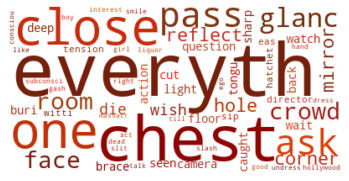

In [250]:
wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict_one_test)
plt.imshow(wordcloud.recolor(color_func=grey_color_func), interpolation='bilinear')
plt.axis("off")
plt.show()

In [251]:
print("The predicted genre of this song is: ", prediction_of_genre)
print("The lyrics of the song '%s' by %s has a %s sentiment." %(test['song'].iloc[index_of_test_lyric], test['artist'].iloc[index_of_test_lyric], sentiment))


The predicted genre of this song is:  Hip-Hop
The lyrics of the song 'you-ll-never-know' by ariana-grande has a negative sentiment.
